# INIT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# SK
# Kmeans & PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules.get_data import get_data

import warnings

# Omitir todos los warnings
warnings.filterwarnings('ignore')

## Constantes

In [3]:
CLUSTER_COL = 'cluster'
FIGSIZE = (12, 8)
FIG_SQUARE = (10,10)

## Importacion datos

### CSVs

In [4]:
# 1. Load and preprocess dataset
df_cal = get_data('exp_calendar.csv')
df_items = get_data('_clusters/items_with_price_range.csv')
df_shops = get_data('exp_shops.csv')
df_s = get_data('daily_sales_with_events.csv')

In [5]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_s.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department,price_range
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Mid
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Low
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Low
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Mid
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Low


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [6]:
# Seleccionar solo años 2014 a 2015 de df_s
df_s = df_s[(df_s['year'] >= 2014) & (df_s['year'] <= 2015)]

# Cambiamos NaN de event por None
df_s['event'] = df_s['event'].fillna('None')

In [7]:
df_s.shape

(8217627, 12)

# ROTACION

## Functions

In [8]:
# CONSTANTES
CLUSTER_COL = 'cluster'
SCALER = RobustScaler

In [9]:
# FUNCTIONS HELPERS
def preprocess_features(data, Scaler=SCALER):
  scaler = Scaler()

  scaled_data = scaler.fit_transform(data)
  return pd.DataFrame(scaled_data, columns=data.columns), scaler

# KMEANS init
def init_kmeans(k):
  return KMeans(
      n_clusters=k,
      random_state=42,
      # init="random",
      init='k-means++', # Para que converja mas rapido
      n_init="auto",
      )

In [10]:
# 1. Preparación de datos
def prepare_data(data):
    # Convertir la columna 'date' a tipo datetime
    data['date'] = pd.to_datetime(data['date'])
    # Renombrar raw_sales a total_sales
    data.rename(columns={'raw_earn': 'total_sales'}, inplace=True)
    return data

# 2. Crear características para análisis de rotación a nivel global, región y tienda
# V2
def create_features(data, level='global'):
    """
    Crea características agregadas para rotación de productos según el nivel ('global', 'region', 'store_code').
    Devuelve un DataFrame con una fila por producto a nivel global, por región, o por tienda.
    """
    # Prefijo de nivel
    prefix = f"{level}_"

    # Definir la lista de columnas a agrupar
    groupby_columns = ['item']

    # Asegurarse de que el DataFrame esté ordenado por item y fecha
    data = data.sort_values(by=['item', 'date'])

    # Crear la columna que indica si hubo ventas (1) o no (0)
    data['has_sales'] = data['units'].apply(lambda x: 1 if x > 0 else 0)

    # Crear un identificador de grupo que cambia cuando hay un cambio en la secuencia de ventas/no ventas
    data['sales_group'] = (data['has_sales'].diff(1) != 0).cumsum()

    # Calcular los días consecutivos con ventas
    data['days_selling'] = data.groupby(['item', 'sales_group'])['has_sales'].transform('size')
    data['days_selling'] = data['days_selling'] * data['has_sales']  # Solo cuenta los días con ventas

    # Calcular los días consecutivos sin ventas
    data['days_no_sales'] = data.groupby(['item', 'sales_group'])['has_sales'].transform('size')
    data['days_no_sales'] = data['days_no_sales'] * (1 - data['has_sales'])  # Solo cuenta los días sin ventas

    # Agrupación y agregación de datos
    feature_data = data.groupby(groupby_columns).agg(
        **{
            f'{prefix}total_units_sold': ('units', 'sum'),  # Total unidades vendidas
            f'{prefix}max_units_sold_in_a_day': ('units', 'max'),  # Máximo número de unidades vendidas en un día
            f'{prefix}std_units_sold_per_day': ('units', 'std'),  # Desviación estándar del número de unidades vendidas por día
            f'{prefix}max_days_selling': ('days_selling', 'max'),  # Máximo número de días consecutivos vendiendo
            f'{prefix}mean_days_selling': ('days_selling', 'mean'),  # Promedio de días consecutivos vendiendo
            # Estas 2 no aportan info => Visto en describe => Son constantes
            # f'{prefix}max_days_no_sales': ('days_no_sales', 'max'),  # Máximo número de días consecutivos sin ventas
            # f'{prefix}mean_days_no_sales': ('days_no_sales', 'mean'),  # Promedio de días consecutivos sin ventas
        }
    ).reset_index()

    return feature_data

# 3.1 Graficar Silhouette Score para varios valores de k
def plot_silhouette(data, level='global', ran=20, detail=None):
    """
    Genera gráficos de Silhouette para diferentes valores de k
    El parametro level se usa solo para construir los nombres de las columnas.
    """
    feature_columns = data.filter(like=f'{level}_').columns
    X = data[feature_columns].fillna(0)
    X_scaled, scaler = preprocess_features(X, Scaler=RobustScaler)

    silhouette_scores = []
    for k in range(2, ran):
        kmeans = init_kmeans(k)
        kmeans.fit(X_scaled)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

    title="Silhouette score"
    if detail:
      title += f' : {detail}'

    fig = px.line(
        x=range(2, ran),
        y=silhouette_scores,
        title=title,
        labels={"x": "k", "y": "Silhouette score"},
    )
    fig.show()

# 3.2 Segmentación por nivel
# V2
def segment_products_kmeans(data, n_clusters=3, level='global'):
    """
    Realiza segmentación de productos con KMeans.
    El parámetro 'level' se usa solo para construir los nombres de las columnas.
    """
    # Filtrar las columnas de características usando el prefijo del nivel
    feature_columns = data.filter(like=f'{level}_').columns
    X = data[feature_columns].fillna(0)  # Reemplazar NaN con 0

    # Preprocesar las características (escalado)
    X_scaled, scaler = preprocess_features(X, Scaler=RobustScaler)

    # Inicializar y ajustar KMeans
    kmeans = init_kmeans(n_clusters)
    clusters = kmeans.fit_predict(X_scaled)

    # Añadir la columna de clusters al DataFrame original
    data[f'{level}_cluster'] = clusters
    silhouette_avg = silhouette_score(X_scaled, clusters)  # Score de silueta
    print(f"El score de silueta promedio a nivel {level} es: {silhouette_avg}")

    # Centroides
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroid_df = pd.DataFrame(centroids, columns=feature_columns)
    centroid_df['cluster'] = range(n_clusters)

    return data, centroid_df

# 4. Visualización de resultados
def create_scatter_plot(data, centroids, level, detail=None):
    """
    Creates a scatter plot to visualize product segmentation.
    """
    plt.figure(figsize=FIGSIZE)

    # Scatterplot of clusters
    sns.scatterplot(data=data,
                    x=f'{level}_total_units_sold',
                    y=f'{level}_max_days_selling',
                    hue=f'{level}_cluster',
                    palette='viridis')

    # Centroids
    sns.scatterplot(data=centroids,
                    x=f'{level}_total_units_sold',
                    y=f'{level}_max_days_selling',
                    s=200,
                    color='red',
                    marker='X')

    title = f'Segmentación de productos por rotación a nivel {level}'
    if detail:
      title += f' : {detail}'

    plt.title(title)
    plt.xlabel('Total de unidades vendidas')
    plt.ylabel('Maximo num de dias continuos vendiendo')
    plt.show()

In [11]:
def analyze_rotation_impact(data, level='global', detail=None):
    """
    Analyze the impact of rotation on product sales.
    """
    rotation_analysis = []
    prefix = f'{level}_' # Solo se usa para construir el nombre de la columna => filtramos df fuera
    cluster_col = f"{prefix}cluster"

    # Agrupar por clúster y price_range para obtener el promedio de unidades
    cluster_data = data.groupby([cluster_col, 'price_range']).agg({
        f'{prefix}total_units_sold': 'mean',
    }).reset_index()

    # Calcular el impacto porcentual de unidades vendidas
    max_units = cluster_data[f'{prefix}total_units_sold'].max()
    cluster_data['units_impact'] = (cluster_data[f'{prefix}total_units_sold'] / max_units) * 100
    rotation_analysis.append(cluster_data)

    # Visualización global
    plt.figure(figsize=(7, 4))
    barplot = sns.barplot(x=cluster_col, y='units_impact', hue='price_range', data=cluster_data)
    title = f'Impacto porcentual de unidades vendidas por clúster {level}'
    if detail:
      title += f' : {detail}'
    plt.title(title)
    plt.xlabel('Clúster')
    plt.ylabel('Cambio porcentual en unidades vendidas')

    # Añadir porcentajes encima de las barras
    for p in barplot.patches:
        barplot.annotate(f'{p.get_height():.1f}%',
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='bottom',
                          fontsize=7, color='black',
                          xytext=(0, 5),
                          textcoords='offset points')

    plt.tight_layout()
    plt.show()

    return rotation_analysis

In [12]:
def pca_and_plot_clusters(data, n_clusters, detail=None):
    """
    Realiza reducción de dimensionalidad con PCA a 2 componentes principales,
    muestra la varianza acumulada y dibuja un scatter plot de los clusters.

    Parámetros:
    - data: DataFrame con las características (sin la columna de clusters).
    - n_clusters: Número de clusters para KMeans.
    """
    # Rellenamos si hay nan con 0 en data
    if data.isna().any().any():
      data = data.fillna(0)
    # Preprocesar las características (escalado)
    X_scaled, scaler = preprocess_features(data, Scaler=RobustScaler)

    # Aplicar PCA para reducir a 2 dimensiones
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Mostrar la varianza explicada acumulada
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()
    print(f"Varianza explicada por cada componente principal: {explained_variance}")
    print(f"Varianza acumulada: {cumulative_variance}")

    # Aplicar KMeans en las 2 dimensiones obtenidas por PCA
    kmeans = init_kmeans(n_clusters)
    clusters = kmeans.fit_predict(X_pca)

    # Crear DataFrame para visualización
    pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = clusters

    # Obtener los centroides del KMeans en las dimensiones reducidas por PCA
    centroids = kmeans.cluster_centers_

    # Plotear los clusters en un scatter plot
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='bright', s=100, alpha=0.7)

    # Añadir los centroides al scatter plot
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroides')

    # Añadir leyenda y título
    plt.legend()
    title = f'Clusters visualizados en 2D con PCA'
    if detail:
      title += f' : {detail}'
    plt.title(title)
    plt.show()

    return pca_df, centroids


## Data (copy)

In [13]:
items = df_items.copy()
shops = df_shops.copy()
df_rot = df_s.copy()

# Agregar la columna region a df_rot desde el df shops usando la columna 'store_code'
df_rot = df_rot.merge(shops[['store_code', 'region']], on='store_code', how='left')

# Agregamos la columna price_range desde df_items a df_rot usando la columna item
df_rot = df_rot.merge(items[['item', 'price_range']], on='item', how='left')

df_rot.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event,region,price_range
0,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2,NewYear,New York,Mid
1,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2,NewYear,New York,Mid
2,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2,NewYear,New York,Low
3,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2,NewYear,New York,Low
4,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2,NewYear,New York,Low


## Global

In [14]:
# numero de valores unicos en 'item' en df_rot
df_rot['item'].nunique() # Falta un producto

3048

In [15]:
# Preparamos datos
data = prepare_data(df_rot)

target='global'

In [16]:
# Creamos caracteristicas por nivel
features = create_features(data, level=target)

In [17]:
# Vemos features ordenadas por 'global_max_days_selling'
display(features.sort_values(by='global_max_days_selling', ascending=False).head(5))
display(features.sort_values(by='global_max_days_selling', ascending=False).tail(5))

,item,global_total_units_sold,global_max_units_sold_in_a_day,global_std_units_sold_per_day,global_max_days_selling,global_mean_days_selling
2809,SUPERMARKET_3_586,327839,209,30.548605,7274,7274.0
2917,SUPERMARKET_3_694,139047,80,12.333010,7253,7253.0
2778,SUPERMARKET_3_555,158395,111,14.376781,7248,7248.0
2936,SUPERMARKET_3_714,148077,88,11.351902,7238,7238.0
2303,SUPERMARKET_3_080,85687,53,6.831523,7237,7237.0


,item,global_total_units_sold,global_max_units_sold_in_a_day,global_std_units_sold_per_day,global_max_days_selling,global_mean_days_selling
494,ACCESORIES_2_079,320,5,0.456223,278,278.0
1372,HOME_&_GARDEN_2_278,326,4,0.527309,267,267.0
2519,SUPERMARKET_3_296,346,13,2.427625,131,131.0
107,ACCESORIES_1_112,96,4,0.513119,80,80.0
326,ACCESORIES_1_335,21,3,0.602080,16,16.0


In [18]:
# Silueta
plot_silhouette(features, level=target)

El score de silueta promedio a nivel global es: 0.8404413532194654


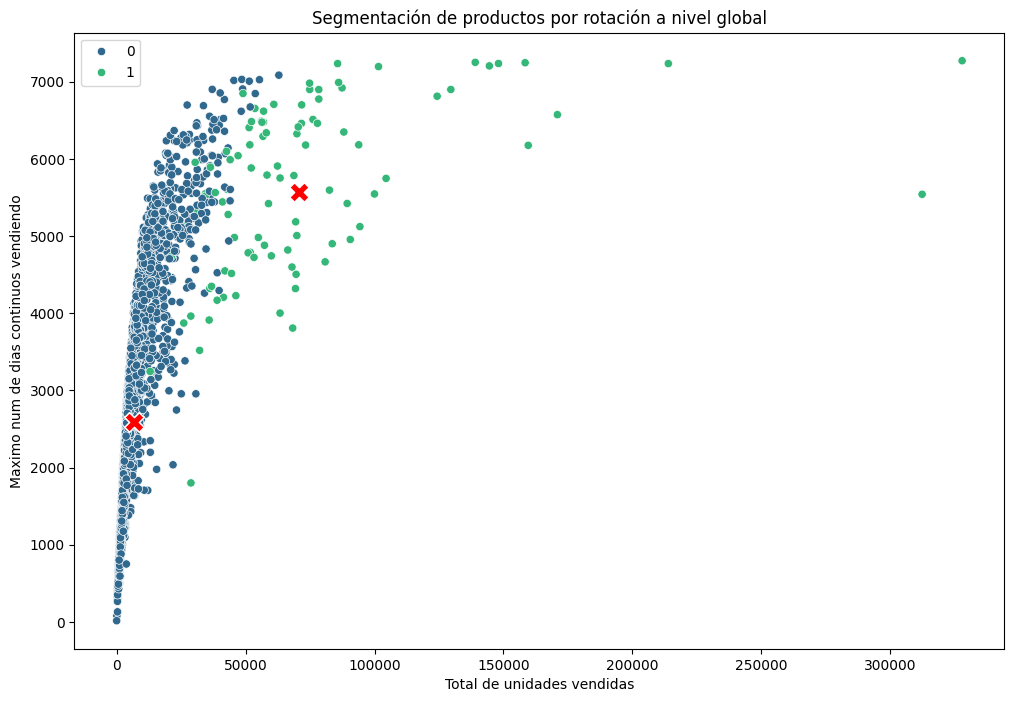

In [19]:
# Habria que tener en cuenta que los clusters pueden variar segun el nivel => No sucede
segmented_data, centroid_df = segment_products_kmeans(features, n_clusters=2, level=target)

create_scatter_plot(segmented_data, centroid_df, level=target)

Varianza explicada por cada componente principal: [0.84315294 0.10961489]
Varianza acumulada: [0.84315294 0.95276783]


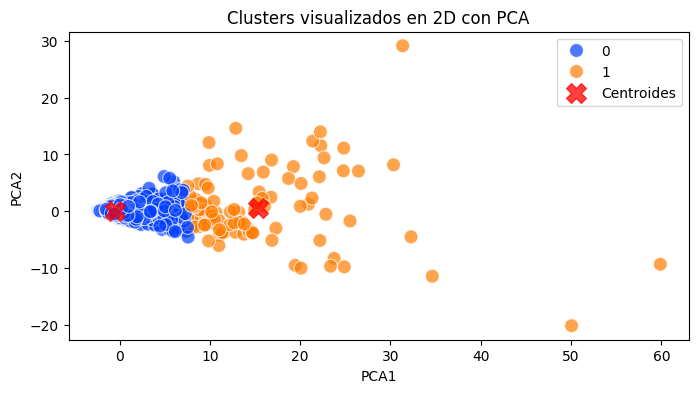

In [20]:
# DIMENSION REDUX para visualizacion 2D
# Seleccionamos solo columnas numericas de features
numeric_data = features.select_dtypes(include=[np.number])
# Aplicamos PCA
pca_df, pca_centroids = pca_and_plot_clusters(numeric_data, n_clusters=2)

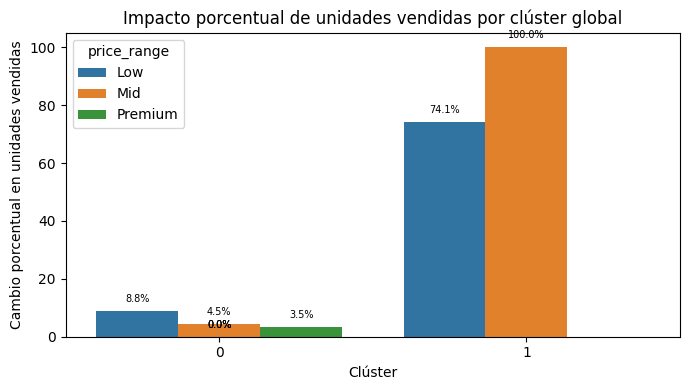

[   global_cluster price_range  global_total_units_sold  units_impact
 0               0         Low              8271.984333      8.774314
 1               0         Mid              4199.320086      4.454331
 2               0     Premium              3278.436364      3.477525
 3               1         Low             69855.204082     74.097273
 4               1         Mid             94275.000000    100.000000]

In [21]:
# Impacto en Global
# Añadimos columna 'price_range' desde items a segmented_data
segmented_data = segmented_data.merge(items[['item', 'price_range']], on='item', how='left')

rotation_impact = analyze_rotation_impact(segmented_data, level=target)
display(rotation_impact)

In [22]:
# NOS FALTA UN PRODUCTO EN ESTOS 2 AÑOS
segmented_data.shape, df_items.shape

((3048, 8), (3049, 4))

In [23]:
# Nos quedamos solo con columna item de items
df_items_with_clusters = df_items[['item']]

# Añadimos columna global_cluster a df_items_with_clusters desde segmented_data usando columna 'item'
df_items_with_clusters = df_items_with_clusters.merge(segmented_data[['item', 'global_cluster']], on='item', how='left')

# Renombramos columna global_cluster a rot_global
df_items_with_clusters.rename(columns={'global_cluster': 'rot_global'}, inplace=True)

In [24]:
# Guardamos el 'item' del producto que tiene NaN en rot_global
item_nan = df_items_with_clusters[df_items_with_clusters['rot_global'].isna()]['item'].values[0]

# Vemos solo el producto que tiene por valor en 'item' la variable item_nan
display(df_items_with_clusters.query(f'item == "{item_nan}"'))

,item,rot_global
1258,HOME_&_GARDEN_2_162,NaN


In [25]:
# Sustituimos NaN por -1 => No está en las ventas globales de estos años
df_items_with_clusters['rot_global'].fillna(-1, inplace=True)

## Region

In [26]:
# Preparamos datos
data_reg = prepare_data(df_rot)

In [27]:
# Valores unicos de region en df_shops
unique_regions = shops['region'].unique()

display(unique_regions)

array(['New York', 'Boston', 'Philadelphia'], dtype=object)

Region: New York


El score de silueta promedio a nivel region es: 0.8107552713694629


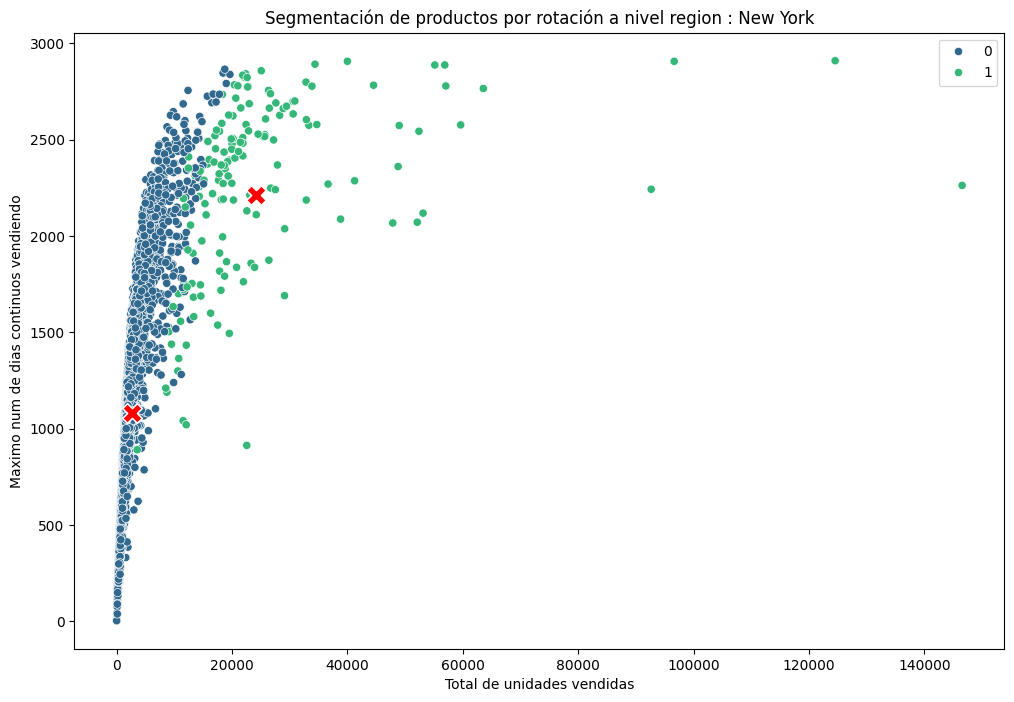

Varianza explicada por cada componente principal: [0.85635768 0.1005441 ]
Varianza acumulada: [0.85635768 0.95690178]


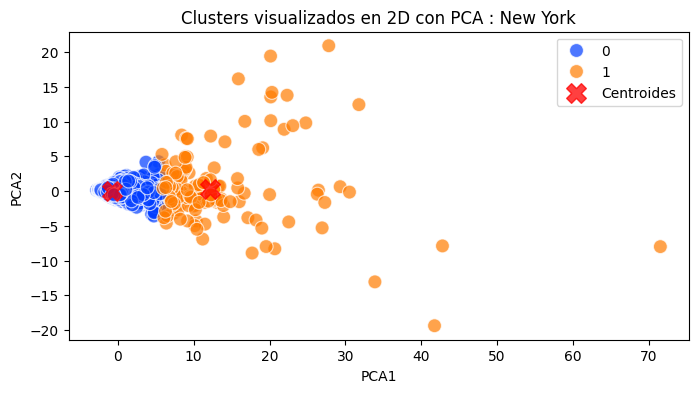

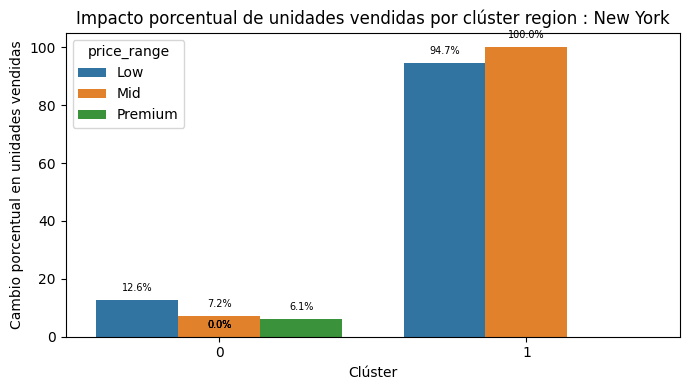

[   region_cluster price_range  region_total_units_sold  units_impact
 0               0         Low              3209.640983     12.614096
 1               0         Mid              1833.315335      7.205048
 2               0     Premium              1564.854545      6.149979
 3               1         Low             24102.132911     94.722937
 4               1         Mid             25444.875000    100.000000]

:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


Region: Boston


El score de silueta promedio a nivel region es: 0.8483477771462768


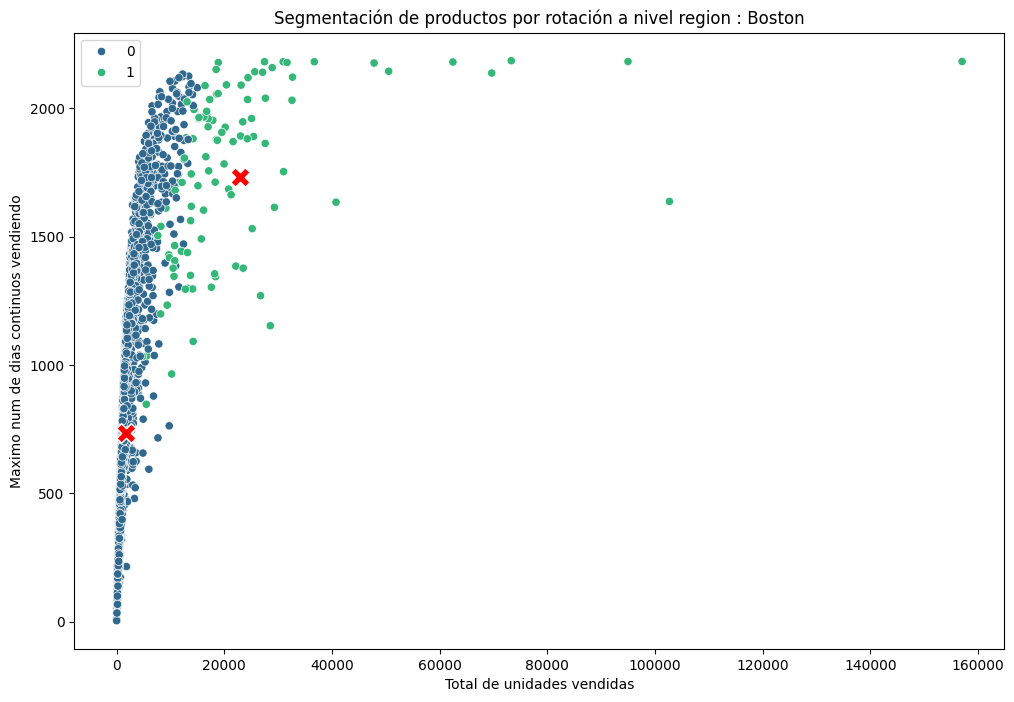

Varianza explicada por cada componente principal: [0.81718836 0.140323  ]
Varianza acumulada: [0.81718836 0.95751136]


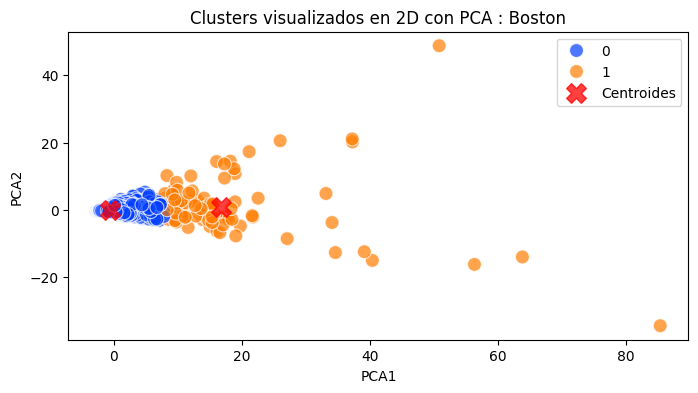

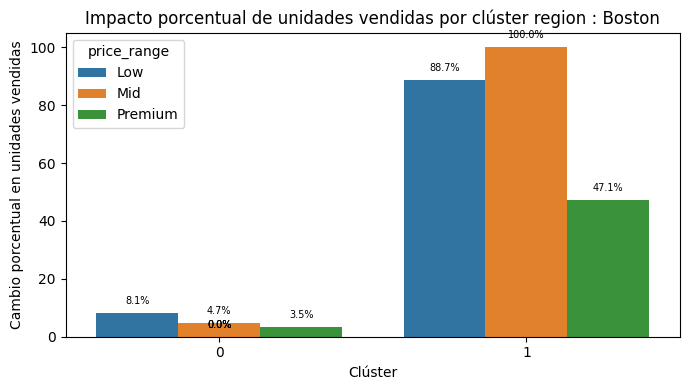

[   region_cluster price_range  region_total_units_sold  units_impact
 0               0         Low              2099.457838      8.097157
 1               0         Mid              1206.171858      4.651945
 2               0     Premium               904.300613      3.487693
 3               1         Low             22985.555556     88.650340
 4               1         Mid             25928.333333    100.000000
 5               1     Premium             12219.500000     47.127981]

:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


Region: Philadelphia


El score de silueta promedio a nivel region es: 0.8299944400475562


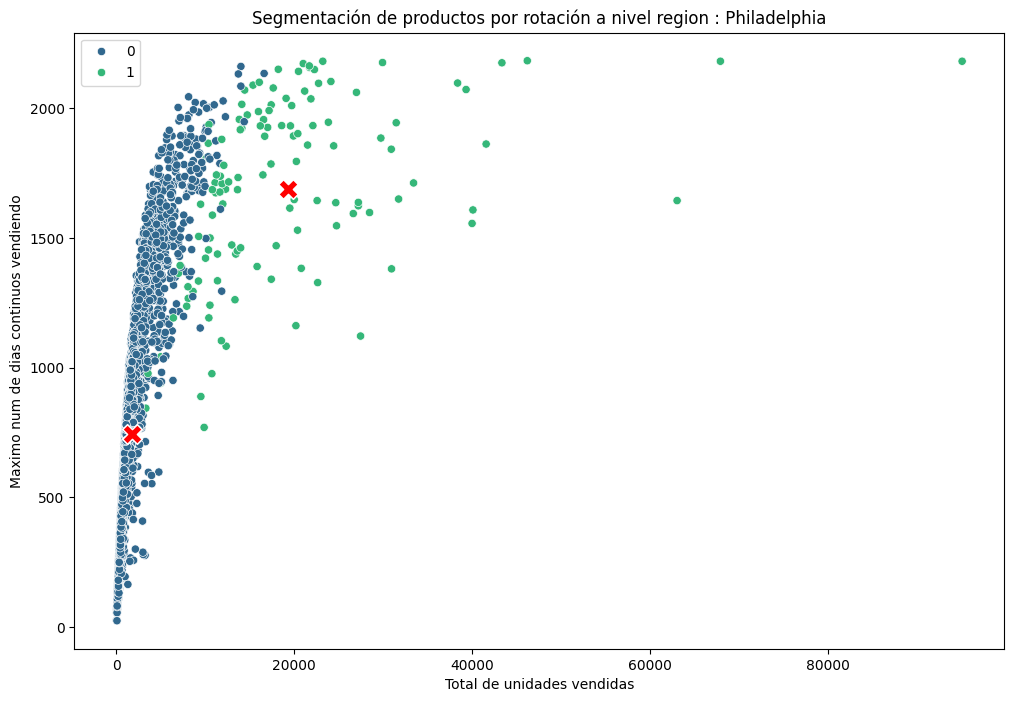

Varianza explicada por cada componente principal: [0.85840893 0.09122096]
Varianza acumulada: [0.85840893 0.94962988]


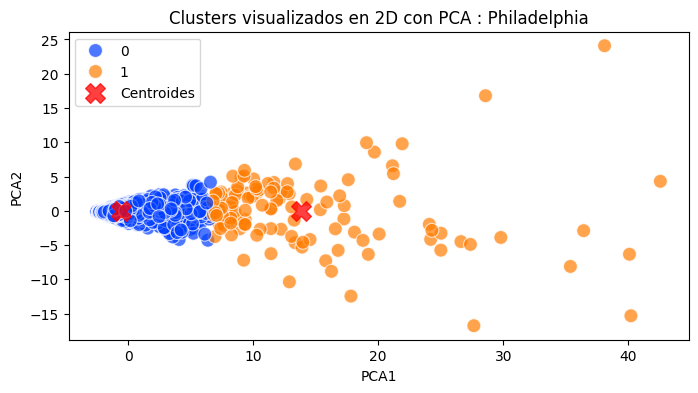

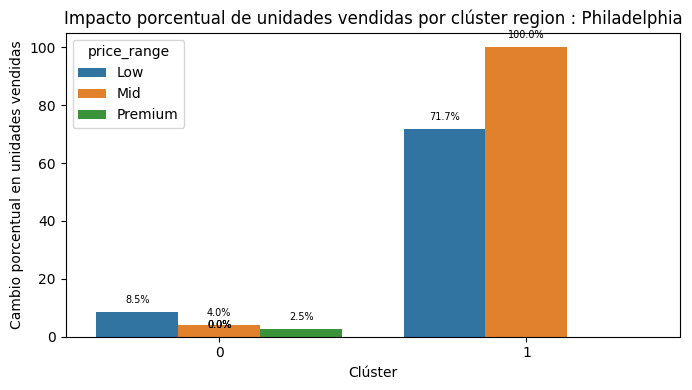

[   region_cluster price_range  region_total_units_sold  units_impact
 0               0         Low              2262.847921      8.516312
 1               0         Mid              1058.246237      3.982749
 2               0     Premium               676.225610      2.545000
 3               1         Low             19046.247934     71.681258
 4               1         Mid             26570.750000    100.000000]

:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::




In [28]:
target = 'region'

for region in unique_regions:
  print(f'Region: {region}')
  # Filtramos por region
  data = data_reg[data_reg[target] == region]
  # Creamos caracteristicas por nivel
  features = create_features(data, level=target)
  # Silueta por region
  plot_silhouette(features, level=target, detail=region) # k=2 => En caso de que silueta indica otra cosa hariamos analisis fuera del loop
  # Segmentamos por region
  segmented_data, centroid_df = segment_products_kmeans(features, n_clusters=2, level=target)
  create_scatter_plot(segmented_data, centroid_df, level=target, detail=region)
  # DIMENSION REDUX
  # Seleccionamos solo columnas numericas de data
  numeric_data = features.select_dtypes(include=[np.number])
  # Aplicamos PCA
  pca_df, pca_centroids = pca_and_plot_clusters(numeric_data, n_clusters=2, detail=region)
  # Impacto por region
  # Añadimos columna 'price_range' desde items a segmented_data
  segmented_data = segmented_data.merge(items[['item', 'price_range']], on='item', how='left')
  rotation_impact_region = analyze_rotation_impact(segmented_data, level=target, detail=region)
  display(rotation_impact_region)
  # Añadimos columnas de clusters a df_items_with_clusters
  df_items_with_clusters = df_items_with_clusters.merge(segmented_data[['item', f'{target}_cluster']], on='item', how='left')
  # Renombramos columna f'{target}_cluster'
  df_items_with_clusters.rename(columns={f'{target}_cluster': f'rot_{target}_{region}'}, inplace=True)
  print(':::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
  print('\n')

In [29]:
df_items_with_clusters.head()

,item,rot_global,rot_region_New York,rot_region_Boston,rot_region_Philadelphia
0,ACCESORIES_1_001,0.0,0.0,0.0,0.0
1,ACCESORIES_1_002,0.0,0.0,0.0,0.0
2,ACCESORIES_1_003,0.0,0.0,0.0,0.0
3,ACCESORIES_1_004,0.0,0.0,0.0,0.0
4,ACCESORIES_1_005,0.0,0.0,0.0,0.0


## Tiendas

In [30]:
# Preparamos datos
data_shops = prepare_data(df_rot)

In [31]:
unique_shops = shops['store_code'].unique()

display(unique_shops)

array(['NYC_1', 'NYC_2', 'NYC_3', 'NYC_4', 'BOS_1', 'BOS_2', 'BOS_3',
       'PHI_1', 'PHI_2', 'PHI_3'], dtype=object)

In [32]:
target = 'store_code'

for shop in unique_shops:
  print(f'Tienda: {shop}')
  # Filtramos por shop
  data = data_reg[data_reg[target] == shop]
  # Creamos caracteristicas por nivel
  features = create_features(data, level=target)
  # Silueta por shop
  plot_silhouette(features, level=target, detail=shop)
  # Segmentamos por shop
  segmented_data, centroid_df = segment_products_kmeans(features, n_clusters=2, level=target)
  create_scatter_plot(segmented_data, centroid_df, level=target, detail=shop)
  # DIMENSION REDUX
  # Seleccionamos solo columnas numericas de data
  numeric_data = features.select_dtypes(include=[np.number])
  # Aplicamos PCA
  pca_df, pca_centroids = pca_and_plot_clusters(numeric_data, n_clusters=2, detail=shop)
  # Impacto por shop
  # Añadimos columna 'price_range' desde items a segmented_data
  segmented_data = segmented_data.merge(items[['item', 'price_range']], on='item', how='left')
  rotation_impact_shop = analyze_rotation_impact(segmented_data, level=target, detail=shop)
  display(rotation_impact_shop)
  # Añadimos columnas de clusters a df_items_with_clusters
  df_items_with_clusters = df_items_with_clusters.merge(segmented_data[['item', f'{target}_cluster']], on='item', how='left')
  # Renombramos columna f'{target}_cluster'
  df_items_with_clusters.rename(columns={f'{target}_cluster': f'rot_store_{shop}'}, inplace=True)
  print(':::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
  print('\n')

Output hidden; open in https://colab.research.google.com to view.

# Guardado clusters

In [33]:
df_items_with_clusters.head()

,item,rot_global,rot_region_New York,rot_region_Boston,rot_region_Philadelphia,rot_store_NYC_1,rot_store_NYC_2,rot_store_NYC_3,rot_store_NYC_4,rot_store_BOS_1,rot_store_BOS_2,rot_store_BOS_3,rot_store_PHI_1,rot_store_PHI_2,rot_store_PHI_3
0,ACCESORIES_1_001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACCESORIES_1_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ACCESORIES_1_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ACCESORIES_1_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ACCESORIES_1_005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Seleccionar solo las columnas numéricas
numeric_cols = df_items_with_clusters.select_dtypes(include='number').columns

# Rellenamos NaN con -1 => No ha tenido ventas en ese nivel
df_items_with_clusters.fillna(-1, inplace=True)

# Sumar los valores por fila => rot_score => 14 seria el maximo => alta rotacion en todos los niveles
df_items_with_clusters['rot_score'] = df_items_with_clusters[numeric_cols].sum(axis=1)

# Convertimos todas las columnas numericas a int
df_items_with_clusters[numeric_cols] = df_items_with_clusters[numeric_cols].astype(int)

# Ordenamos por rot_score ascending = False
df_items_with_clusters = df_items_with_clusters.sort_values(by='rot_score', ascending=False)

# Vemos head
display(df_items_with_clusters.head())
# Vemos tail
display(df_items_with_clusters.tail())


,item,rot_global,rot_region_New York,rot_region_Boston,rot_region_Philadelphia,rot_store_NYC_1,rot_store_NYC_2,rot_store_NYC_3,rot_store_NYC_4,rot_store_BOS_1,rot_store_BOS_2,rot_store_BOS_3,rot_store_PHI_1,rot_store_PHI_2,rot_store_PHI_3,rot_score
2905,SUPERMARKET_3_681,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14.0
2553,SUPERMARKET_3_329,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14.0
2686,SUPERMARKET_3_462,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14.0
2937,SUPERMARKET_3_714,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14.0
2314,SUPERMARKET_3_090,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14.0


,item,rot_global,rot_region_New York,rot_region_Boston,rot_region_Philadelphia,rot_store_NYC_1,rot_store_NYC_2,rot_store_NYC_3,rot_store_NYC_4,rot_store_BOS_1,rot_store_BOS_2,rot_store_BOS_3,rot_store_PHI_1,rot_store_PHI_2,rot_store_PHI_3,rot_score
1067,HOME_&_GARDEN_1_512,0,0,0,0,0,0,-1,-1,0,0,0,0,0,0,-2.0
955,HOME_&_GARDEN_1_400,0,0,0,0,0,0,0,-1,0,0,0,-1,-1,0,-3.0
2520,SUPERMARKET_3_296,0,0,0,0,-1,-1,0,-1,0,-1,0,0,-1,0,-5.0
326,ACCESORIES_1_335,0,0,0,-1,0,0,-1,0,-1,0,0,-1,-1,-1,-6.0
1258,HOME_&_GARDEN_2_162,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-14.0


In [35]:
# Convertimos columna rot_score a int
df_items_with_clusters['rot_score'] = df_items_with_clusters['rot_score'].astype(int)

# Informes adicionales

In [36]:
# Agrupamos df_rot por item y suma de unidades y total_sales
def group_sales_data(data, target_col='item'):
    '''
    data => df con ventas diarias
    target_col => col por la que agrupamos
    '''
    # Agrupar por target_col y sumar unidades y ventas brutas
    grouped_data = data.groupby(target_col).agg({
        'units': 'sum',
        'total_sales': 'sum'
    }).reset_index()

    return grouped_data

In [37]:
# Distribucion de clusters para unidades vendidas y ventas
def plot_cluster_distribution(data, data_labeled, cluster_col, target_col='item'):
    '''
    data => df con ventas diarias agrupadas
    data_labeled => df con clusters
    '''
    # Añadimos cluster col a data de ventas
    data = data.merge(data_labeled[[target_col, cluster_col]], on=target_col, how='left')

    # Agrupamos por cluster_col
    grouped_data = data.groupby(cluster_col).agg({
        'units': 'sum',
        'total_sales': 'sum',
        'item': 'count'
    }).reset_index()

    # Renombramos 'item' a items_count
    grouped_data.rename(columns={'item': 'items_count'}, inplace=True)

    # Calcular el total de unidades y ventas en el DataFrame filtrado
    total_units = grouped_data['units'].sum()
    total_sales = grouped_data['total_sales'].sum()
    total_items = grouped_data['items_count'].sum()  # Calcular el total de ítems

    # Calcular porcentajes de unidades y ventas para cada clúster
    grouped_data['units_pct'] = (grouped_data['units'] / total_units) * 100
    grouped_data['total_sales_pct'] = (grouped_data['total_sales'] / total_sales) * 100
    # Calcular porcentaje de ítems por clúster
    grouped_data['items_pct'] = (grouped_data['items_count'] / total_items) * 100

    # Crear figura y ejes para los gráficos
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Tres columnas

    # Visualización del porcentaje de ítems por clúster
    barplot_items = sns.barplot(x=cluster_col, y='items_pct', data=grouped_data, palette='bright', ax=axes[0])

    # Añadir el porcentaje de ítems encima de las barras
    for p in barplot_items.patches:
        barplot_items.annotate(f'{p.get_height():.1f}%',
                               (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='bottom',
                               fontsize=10, color='black',
                               xytext=(0, 5), textcoords='offset points')

    axes[0].set_title(f'Porcentaje de ítems por {cluster_col}')
    axes[0].set_xlabel(cluster_col)
    axes[0].set_ylabel('Porcentaje de ítems')

    # Visualización de la distribución de unidades vendidas
    barplot_units = sns.barplot(x=cluster_col, y='units_pct', data=grouped_data, palette='bright', ax=axes[1])

    # Añadir porcentajes encima de las barras
    for p in barplot_units.patches:
        barplot_units.annotate(f'{p.get_height():.1f}%',
                               (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='bottom',
                               fontsize=10, color='black',
                               xytext=(0, 5), textcoords='offset points')

    axes[1].set_title(f'Distribución porcentual de unidades vendidas por {cluster_col}')
    axes[1].set_xlabel(cluster_col)
    axes[1].set_ylabel('Porcentaje de unidades vendidas')

    # Visualización de la distribución de ingresos
    barplot_earnings = sns.barplot(x=cluster_col, y='total_sales_pct', data=grouped_data, palette='bright', ax=axes[2])

    # Añadir porcentajes encima de las barras
    for p in barplot_earnings.patches:
        barplot_earnings.annotate(f'{p.get_height():.1f}%',
                                  (p.get_x() + p.get_width() / 2., p.get_height()),
                                  ha='center', va='bottom',
                                  fontsize=10, color='black',
                                  xytext=(0, 5), textcoords='offset points')

    axes[2].set_title(f'Distribución porcentual de ingresos por {cluster_col}')
    axes[2].set_xlabel(cluster_col)
    axes[2].set_ylabel('Porcentaje de ingresos')

    plt.tight_layout()  # Ajustar el espaciado
    plt.show()


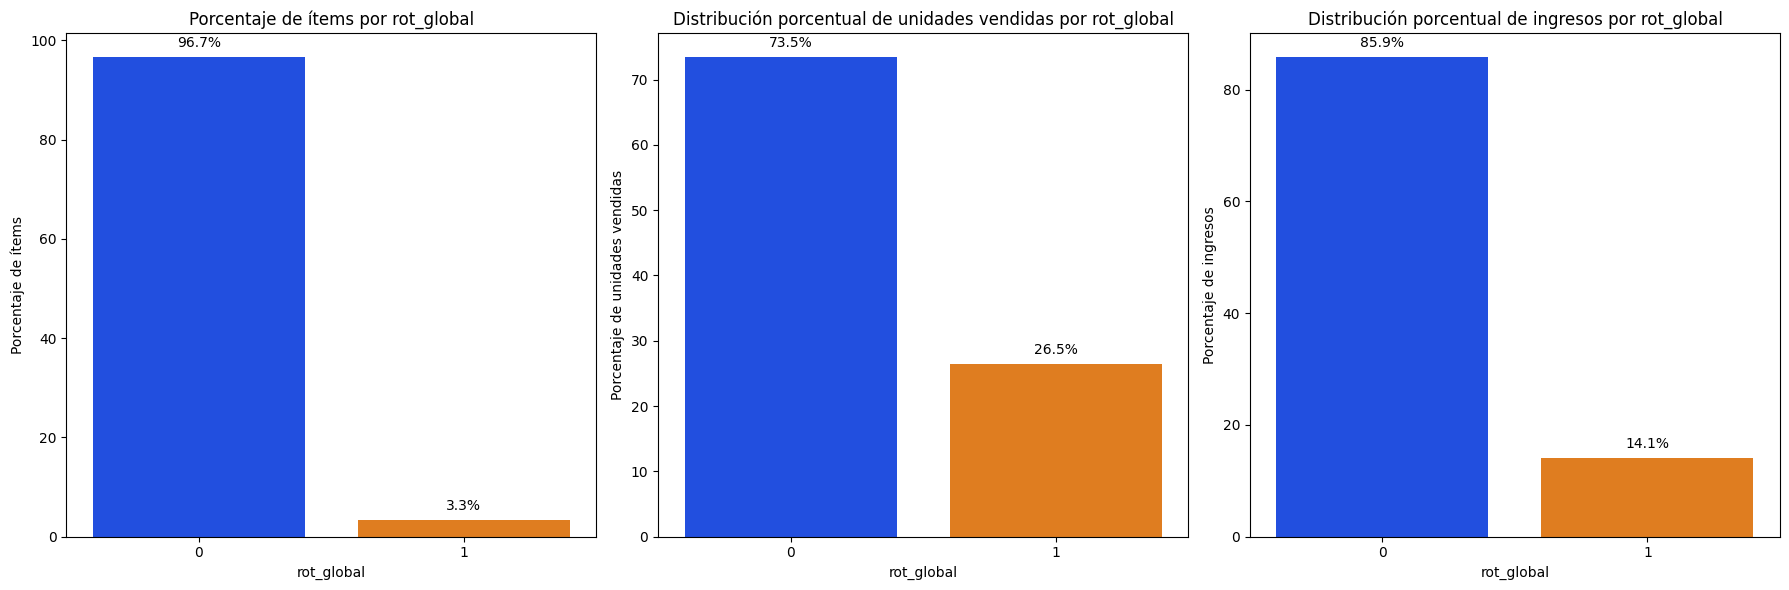

In [38]:
df_grouped = group_sales_data(df_rot, target_col='item')

cluster_col = 'rot_global'

plot_cluster_distribution(df_grouped, df_items_with_clusters, cluster_col, target_col='item')

In [39]:
clusters_list = df_items_with_clusters.columns.tolist()

Cluster: rot_region_New York


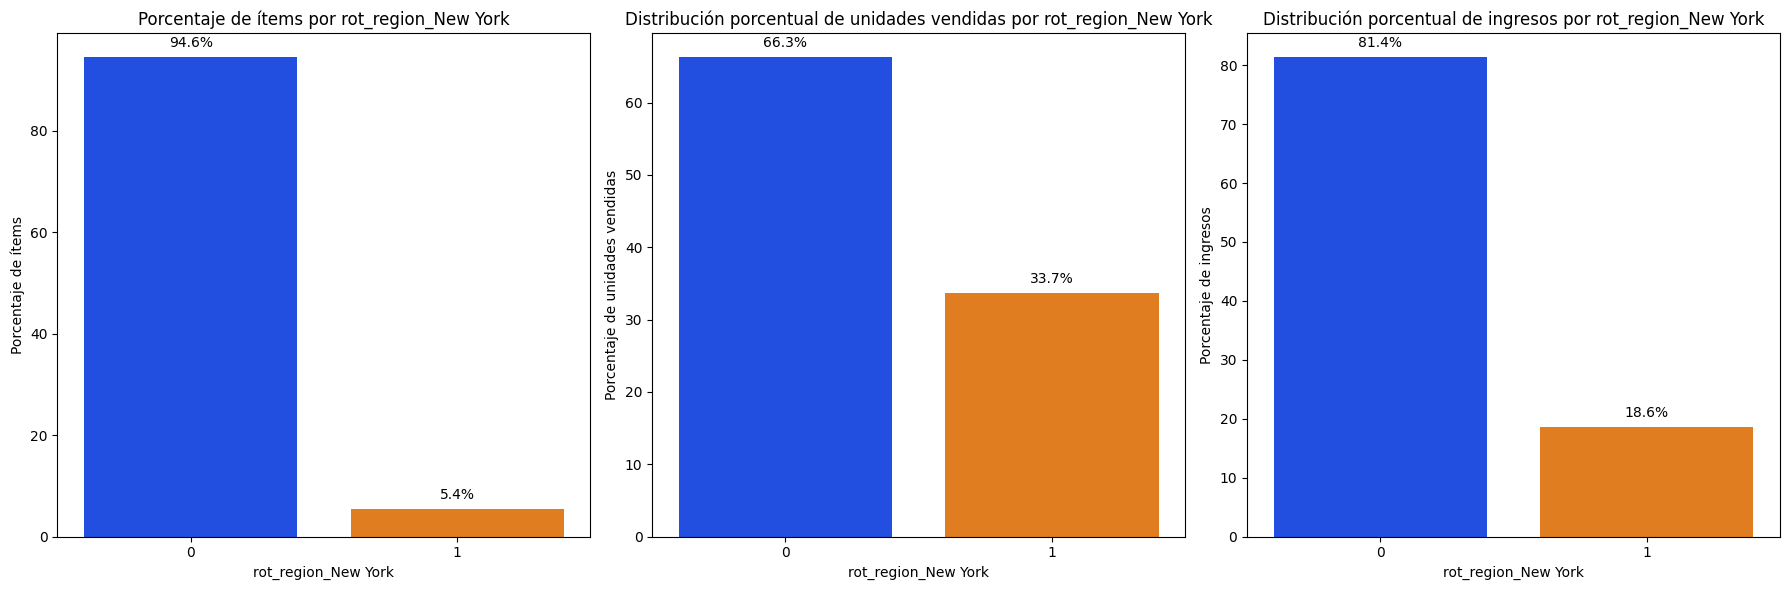

Cluster: rot_region_Boston


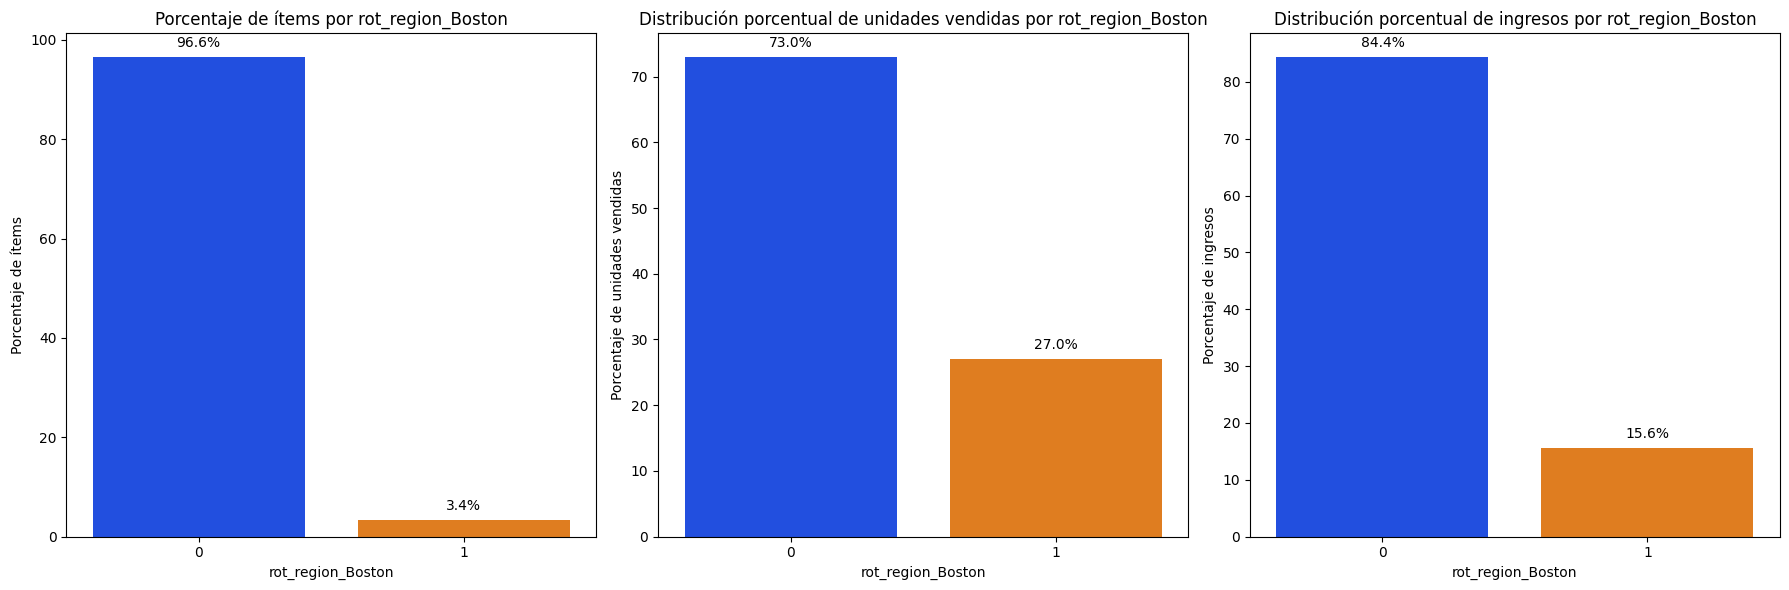

Cluster: rot_region_Philadelphia


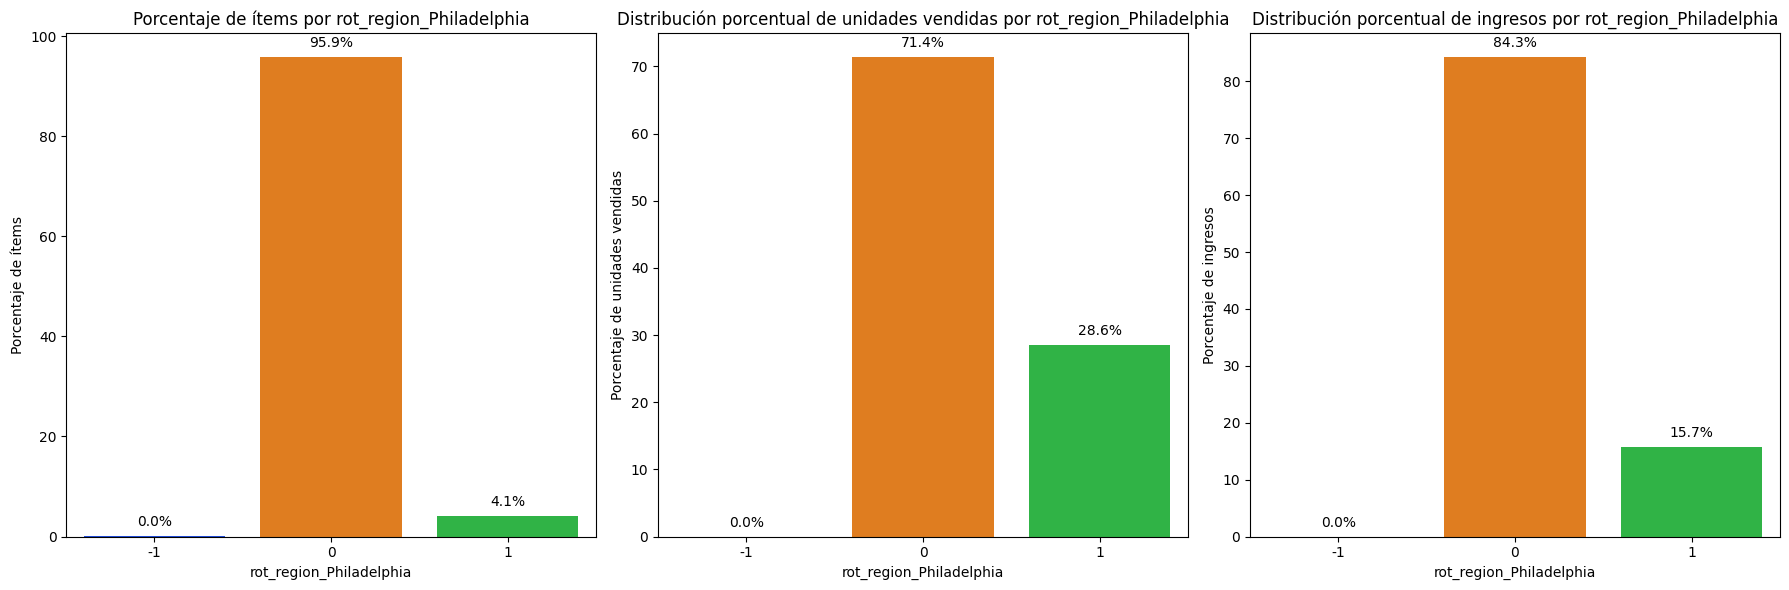

In [40]:
# Filtrar los elementos que comienzan con 'rot_region_'
filtered_clusters = [cluster for cluster in clusters_list if cluster.startswith('rot_region_')]

for cluster in filtered_clusters:
  print(f'Cluster: {cluster}')
  plot_cluster_distribution(df_grouped, df_items_with_clusters, cluster, target_col='item')

Cluster: rot_store_NYC_1


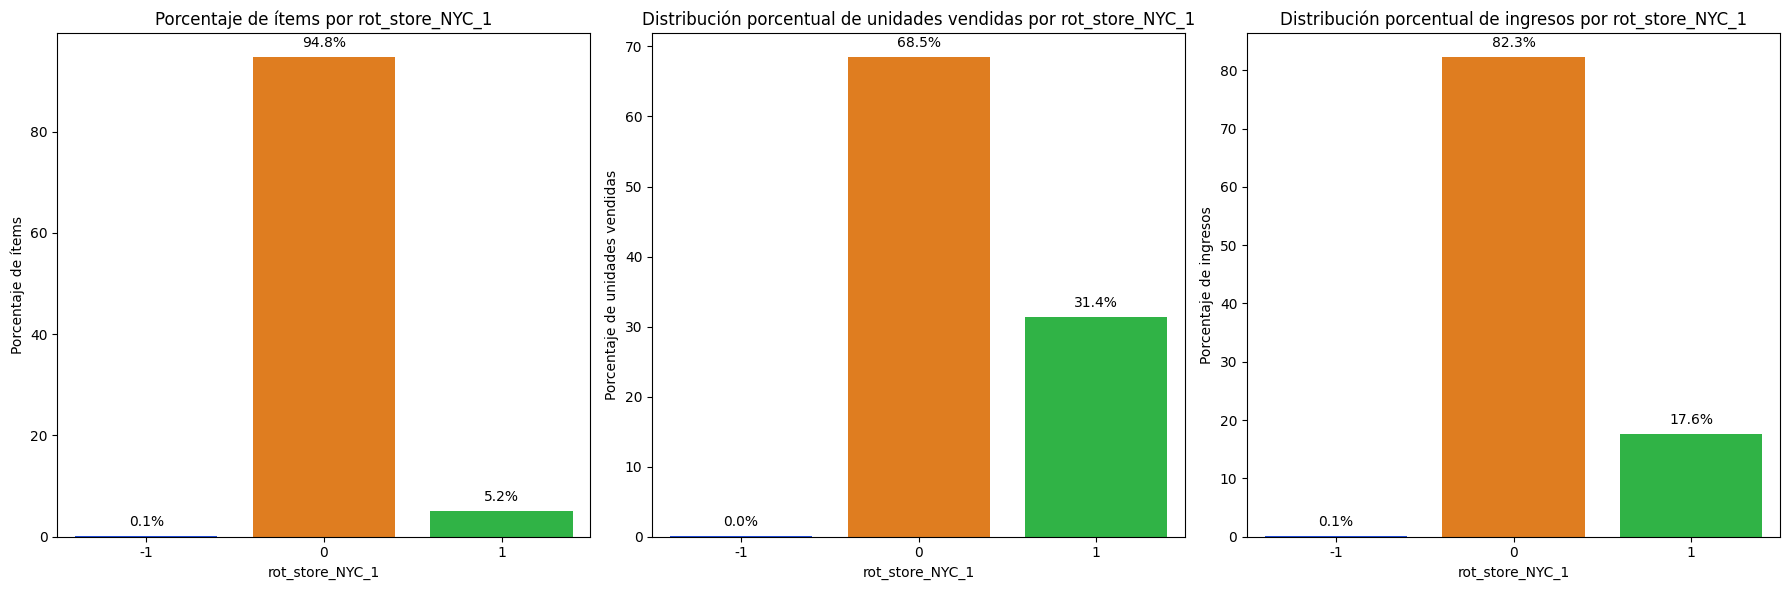

Cluster: rot_store_NYC_2


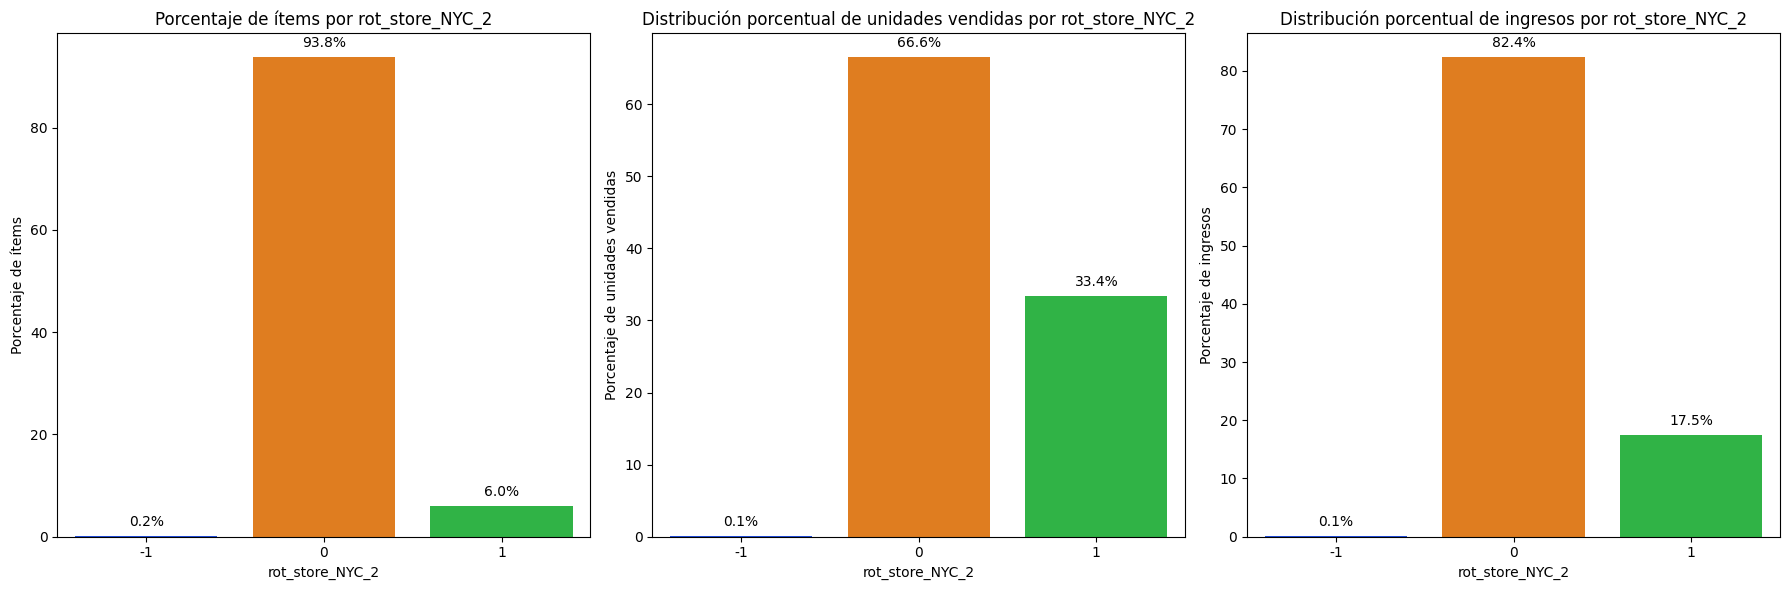

Cluster: rot_store_NYC_3


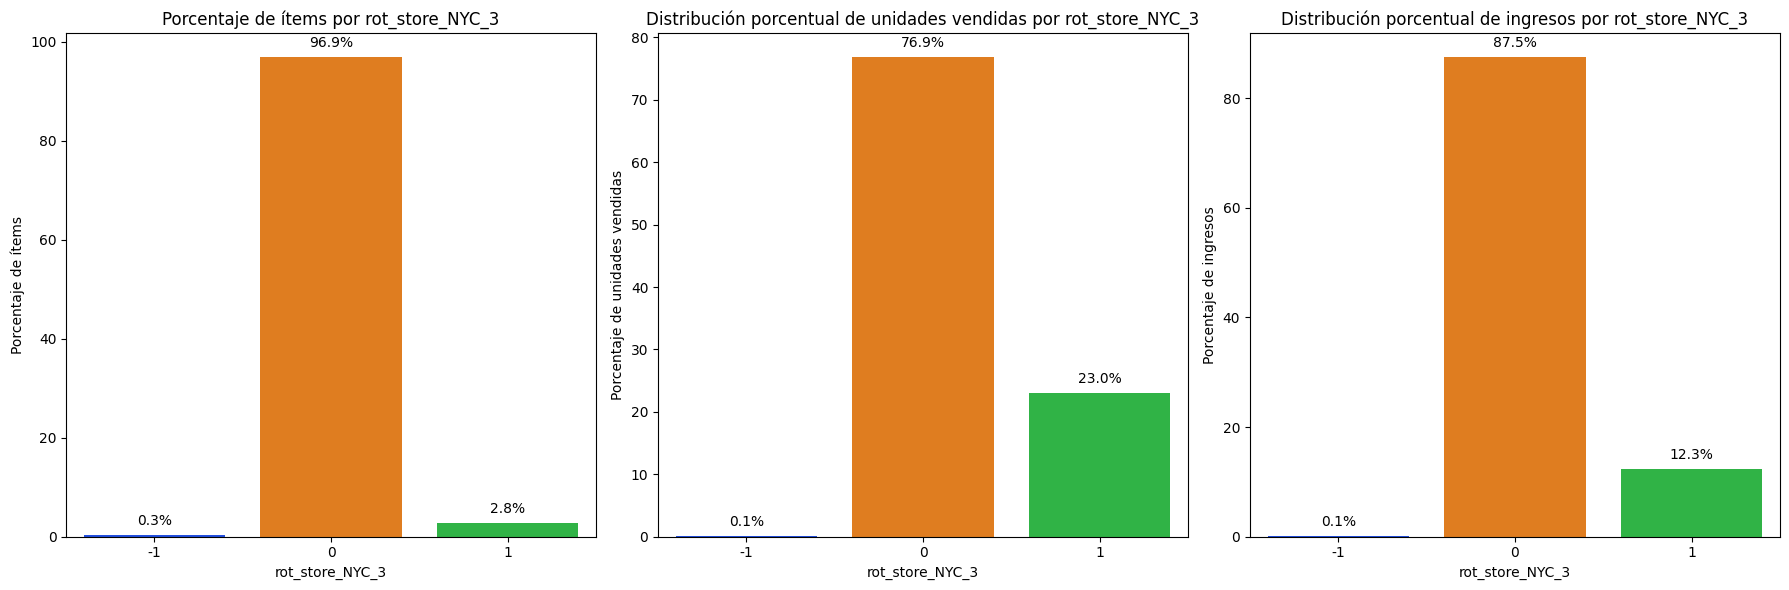

Cluster: rot_store_NYC_4


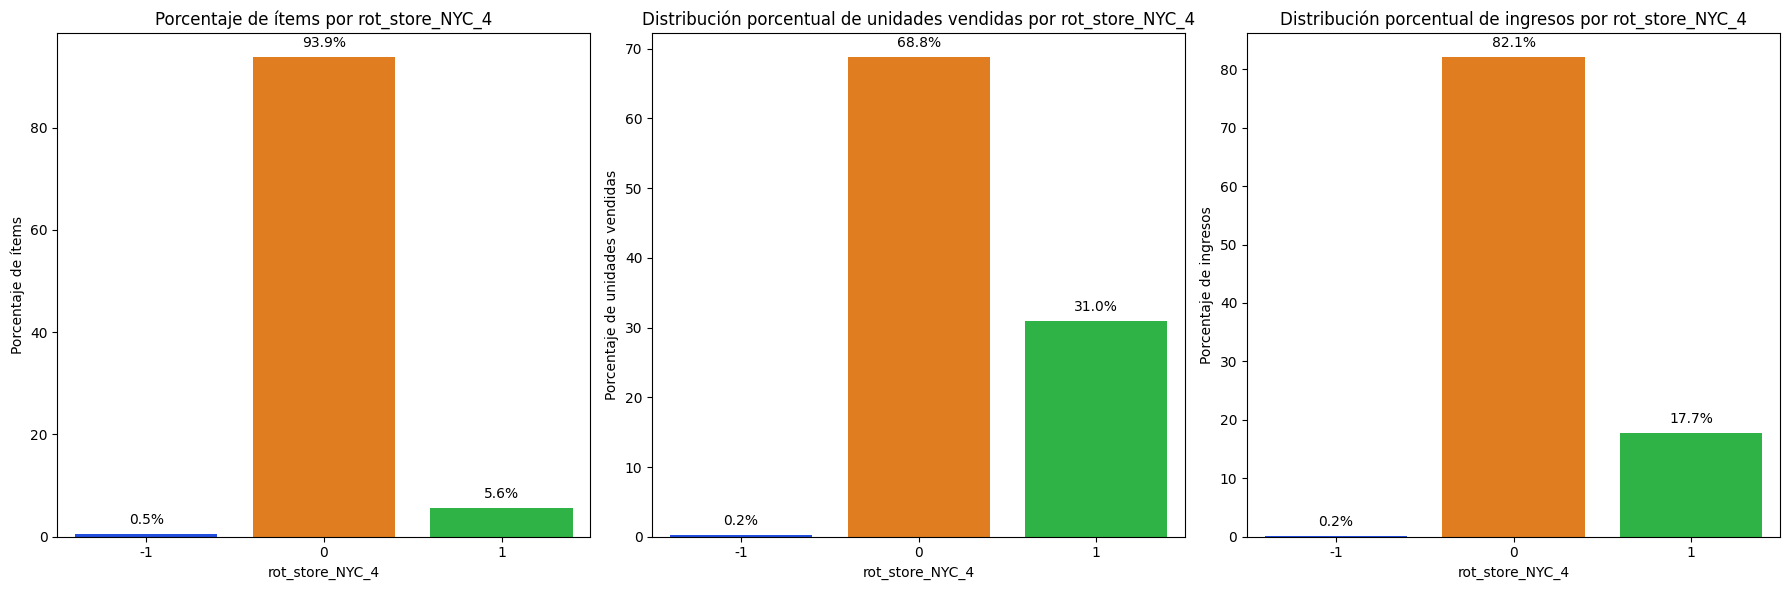

Cluster: rot_store_BOS_1


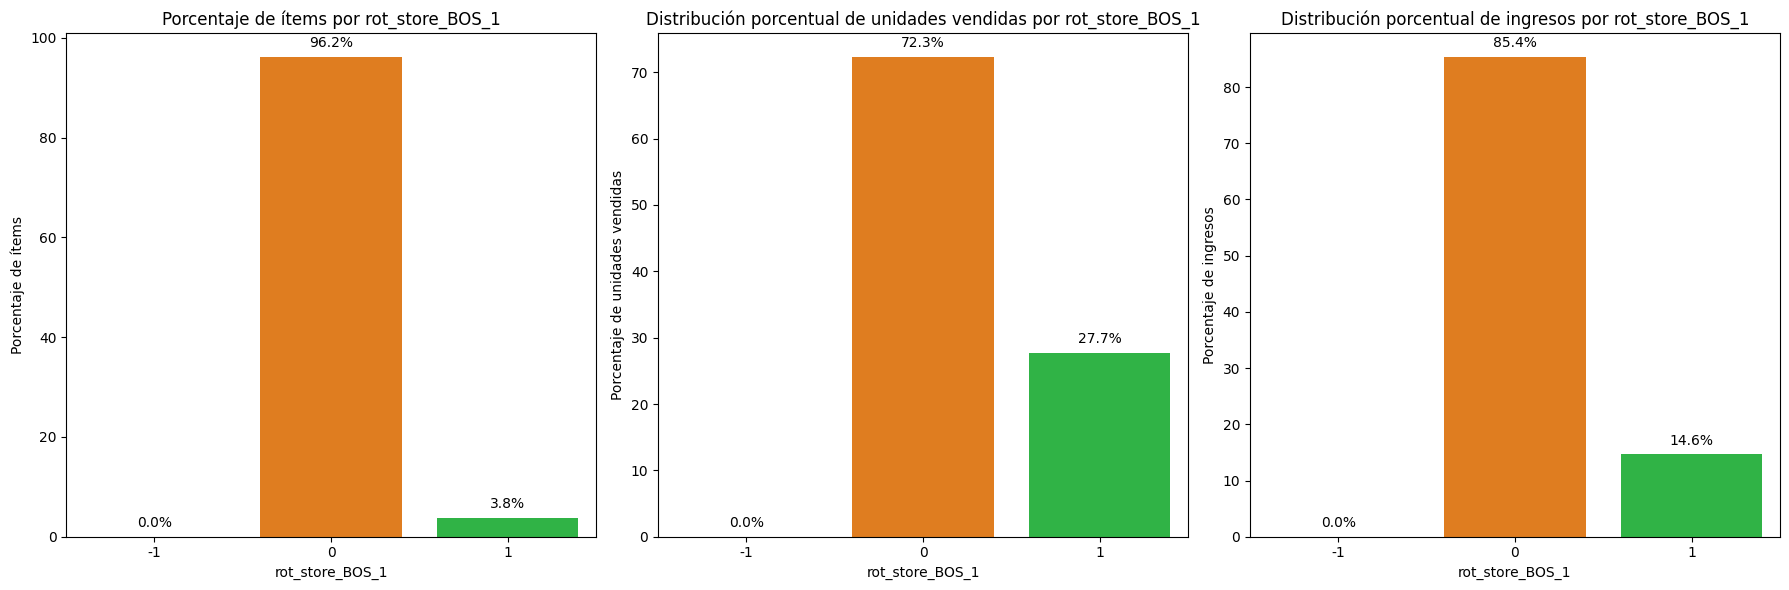

Cluster: rot_store_BOS_2


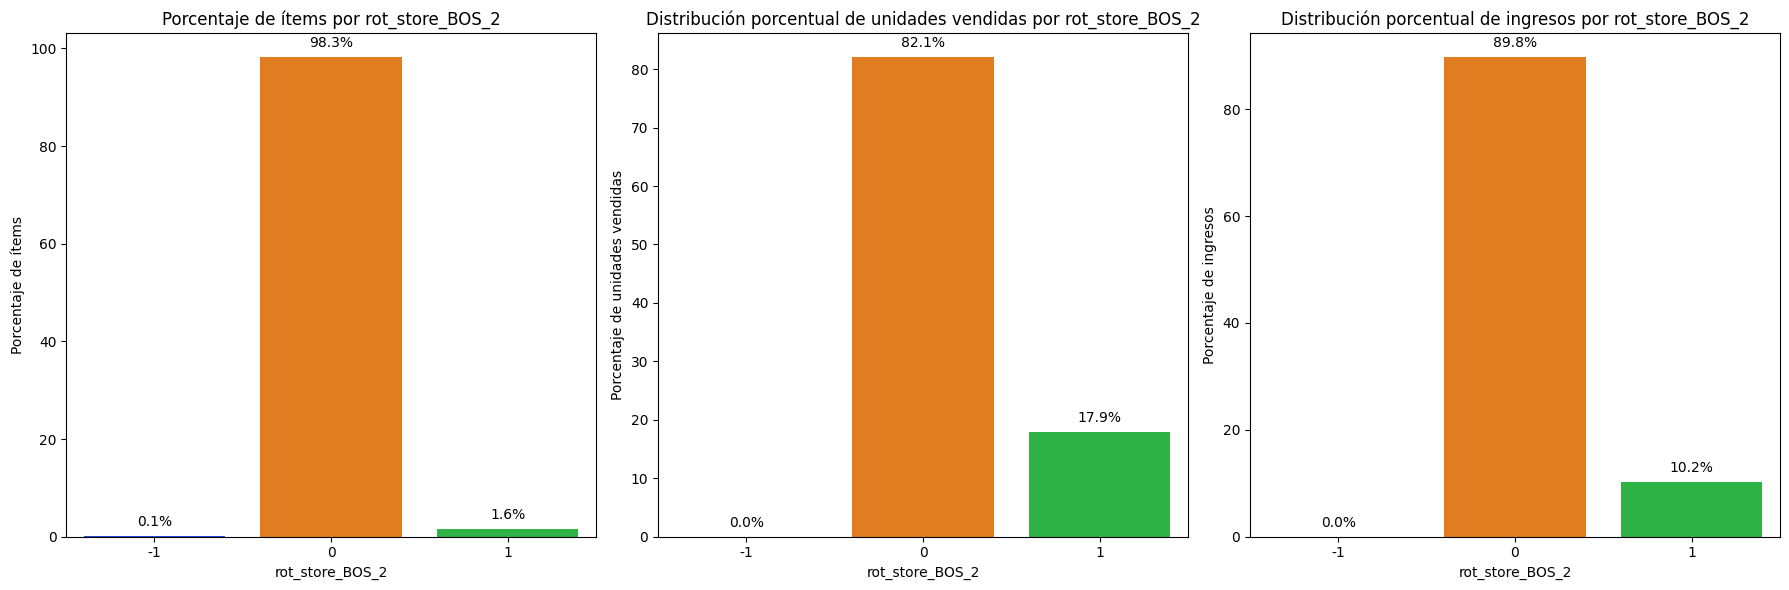

Cluster: rot_store_BOS_3


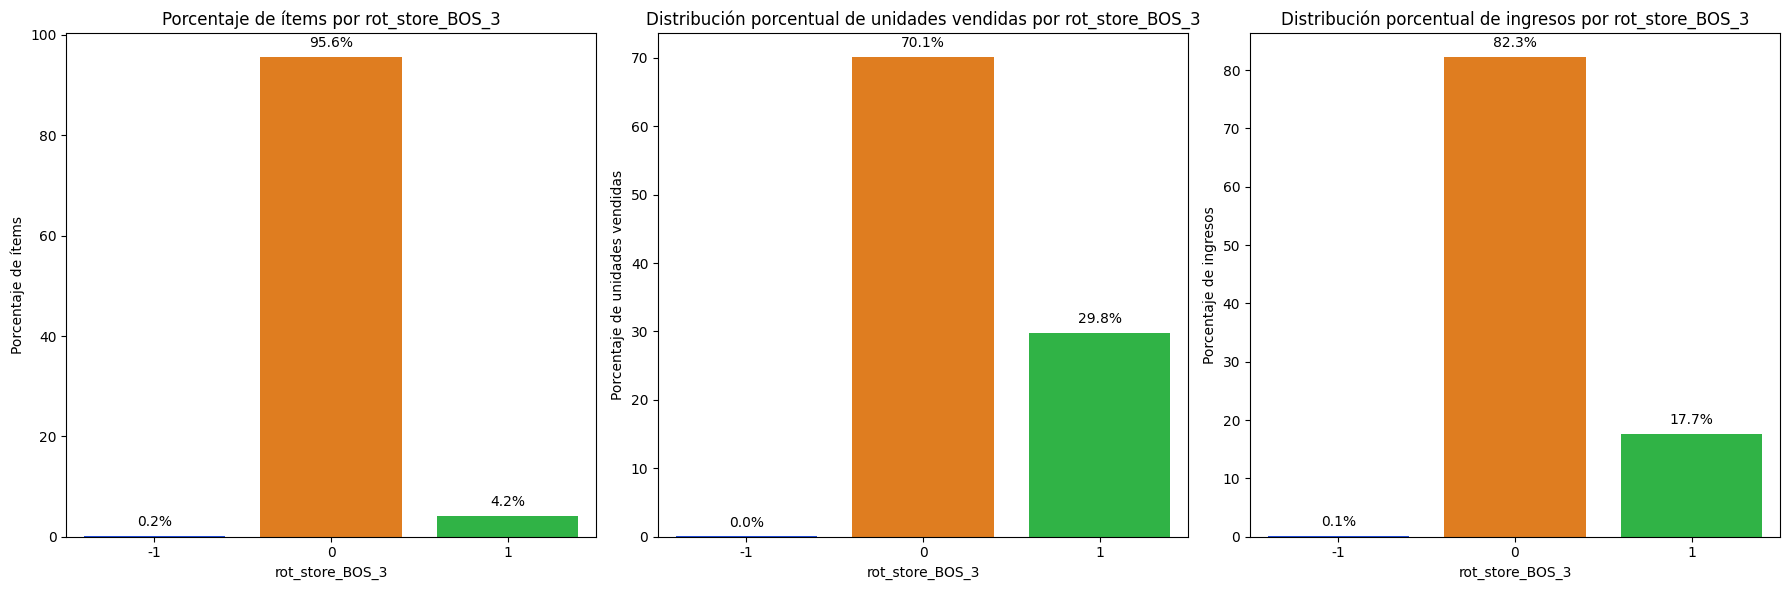

Cluster: rot_store_PHI_1


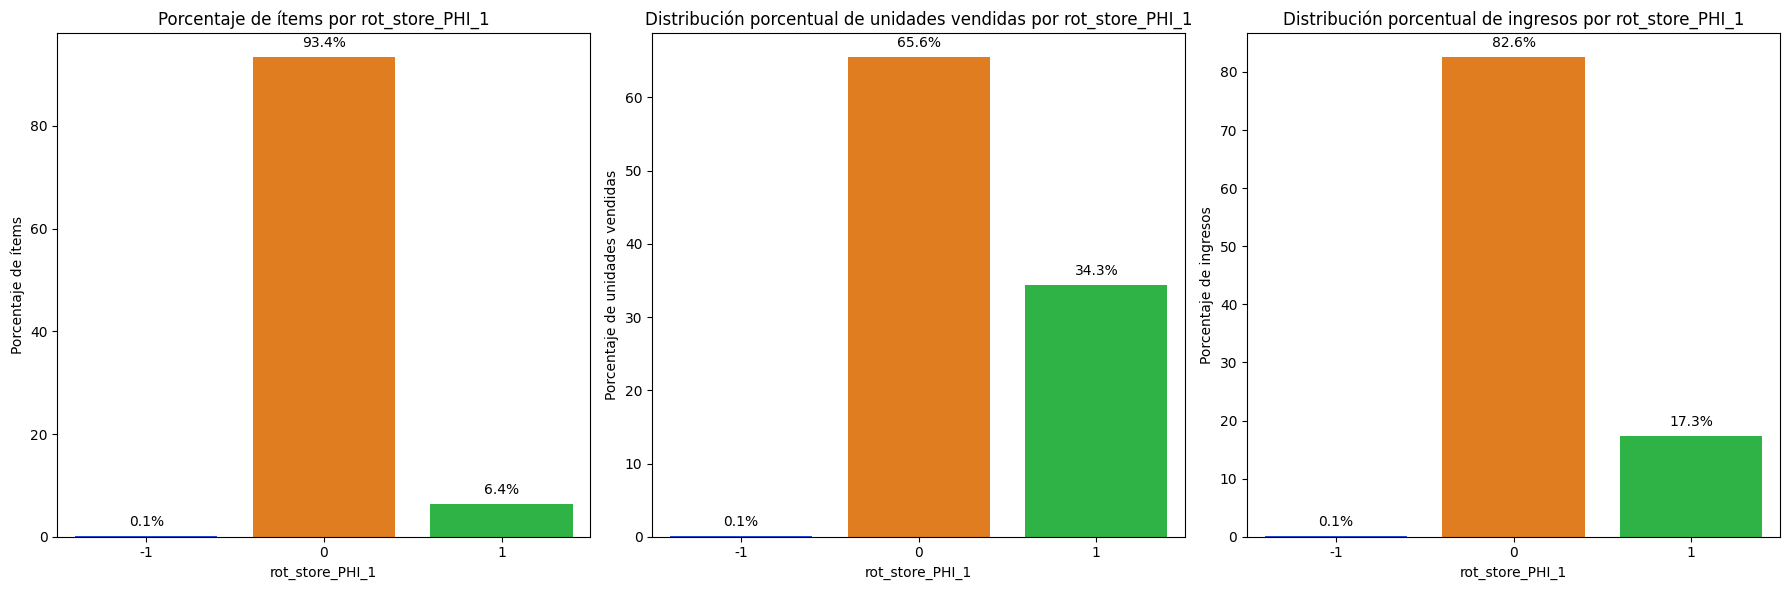

Cluster: rot_store_PHI_2


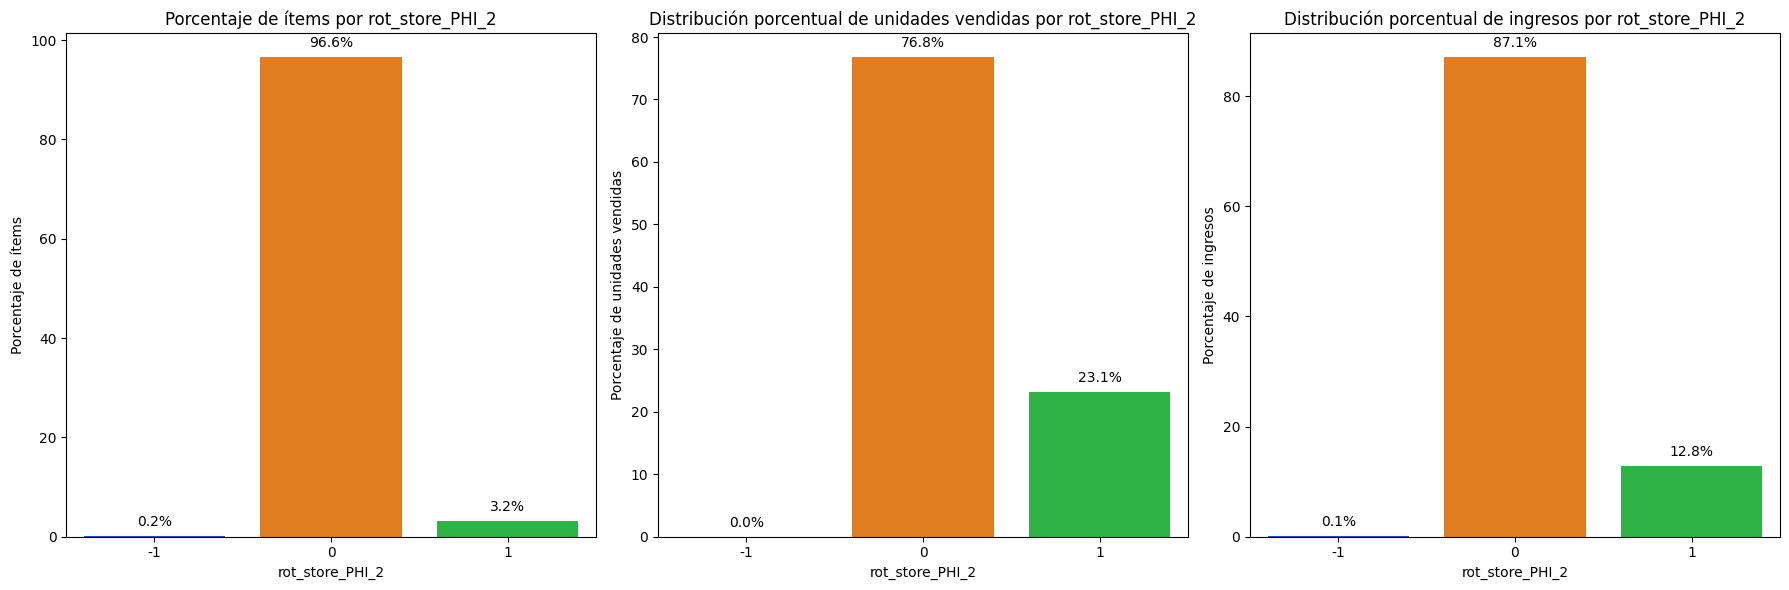

Cluster: rot_store_PHI_3


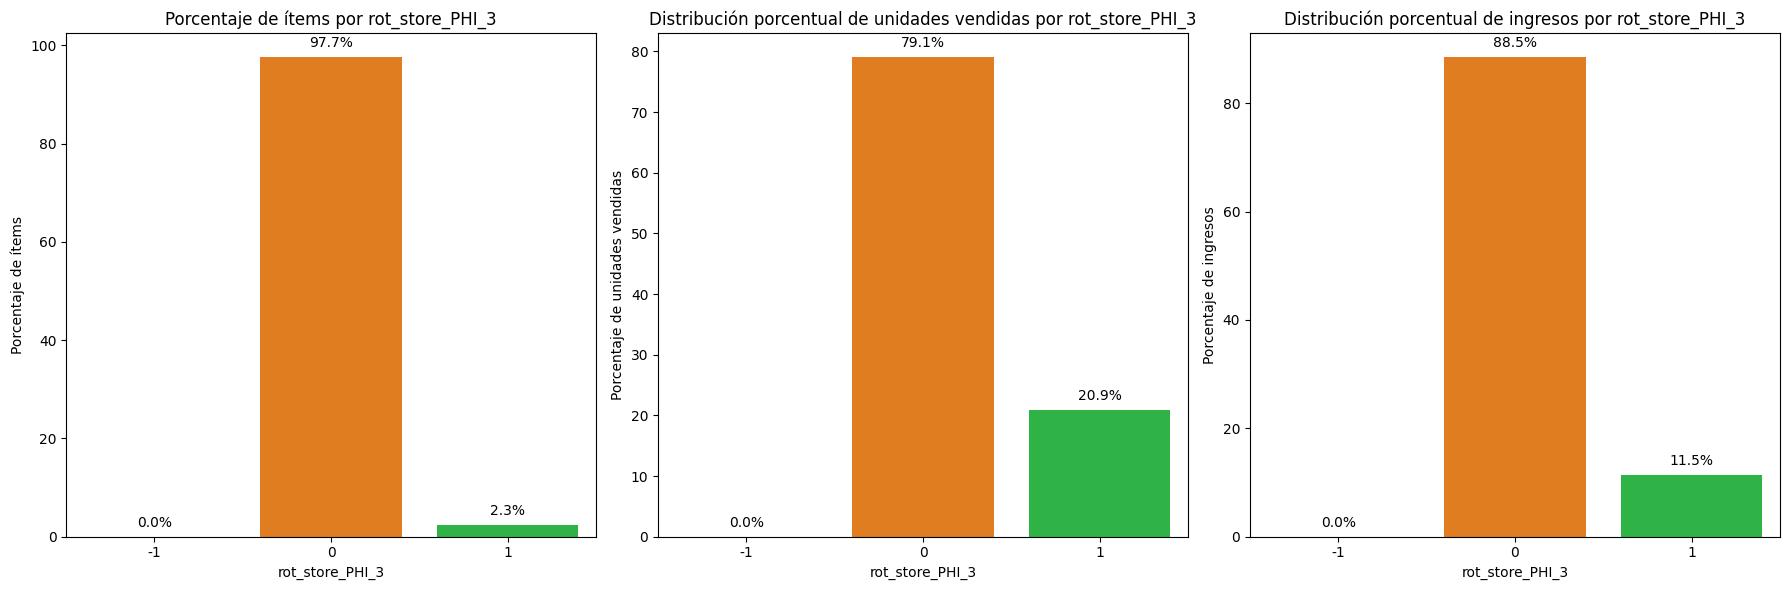

In [41]:
# Filtrar los elementos que comienzan con 'rot_store_'
filtered_clusters = [cluster for cluster in clusters_list if cluster.startswith('rot_store_')]

for cluster in filtered_clusters:
  print(f'Cluster: {cluster}')
  plot_cluster_distribution(df_grouped, df_items_with_clusters, cluster, target_col='item')

In [42]:
# Vemos rot_score menor que 0
not_selling_items = df_items_with_clusters[df_items_with_clusters['rot_score'] < 0]

# Ordenamos por ascending True
not_selling_items = not_selling_items.sort_values(by='rot_score', ascending=True)

# Vemos head
display(not_selling_items.shape)
display(not_selling_items)

(35, 16)

,item,rot_global,rot_region_New York,rot_region_Boston,rot_region_Philadelphia,rot_store_NYC_1,rot_store_NYC_2,rot_store_NYC_3,rot_store_NYC_4,rot_store_BOS_1,rot_store_BOS_2,rot_store_BOS_3,rot_store_PHI_1,rot_store_PHI_2,rot_store_PHI_3,rot_score
1258,HOME_&_GARDEN_2_162,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-14
326,ACCESORIES_1_335,0,0,0,-1,0,0,-1,0,-1,0,0,-1,-1,-1,-6
2520,SUPERMARKET_3_296,0,0,0,0,-1,-1,0,-1,0,-1,0,0,-1,0,-5
955,HOME_&_GARDEN_1_400,0,0,0,0,0,0,0,-1,0,0,0,-1,-1,0,-3
1067,HOME_&_GARDEN_1_512,0,0,0,0,0,0,-1,-1,0,0,0,0,0,0,-2
836,HOME_&_GARDEN_1_278,0,0,0,0,0,-1,-1,0,0,0,0,0,0,0,-2
2819,SUPERMARKET_3_595,0,0,0,0,-1,0,-1,0,0,0,0,0,0,0,-2
943,HOME_&_GARDEN_1_386,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,-2
119,ACCESORIES_1_124,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,-1
1820,SUPERMARKET_1_212,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,-1


In [43]:
# seleccionamos el primer item de la lista
not_selling_items.iloc[0].T

,1258
item,HOME_&_GARDEN_2_162
rot_global,-1
rot_region_New York,-1
rot_region_Boston,-1
rot_region_Philadelphia,-1
rot_store_NYC_1,-1
rot_store_NYC_2,-1
rot_store_NYC_3,-1
rot_store_NYC_4,-1
rot_store_BOS_1,-1


In [44]:
# Vemos suma de unidades en df_rot del item = ACCESORIES_1_335
df_rot[df_rot['item'] == 'ACCESORIES_1_335']['units'].sum()

21

In [45]:
# Vemos head de items que tengan 1 en rot_global & rot_score menor que 14
# Alta rotacion global que no se venden en alguna zona
df_items_with_clusters[(df_items_with_clusters['rot_global'] == 1) & (df_items_with_clusters['rot_score'] < 14)].head(5)

,item,rot_global,rot_region_New York,rot_region_Boston,rot_region_Philadelphia,rot_store_NYC_1,rot_store_NYC_2,rot_store_NYC_3,rot_store_NYC_4,rot_store_BOS_1,rot_store_BOS_2,rot_store_BOS_3,rot_store_PHI_1,rot_store_PHI_2,rot_store_PHI_3,rot_score
2859,SUPERMARKET_3_635,1,1,1,1,1,1,1,1,1,1,1,1,0,1,13
2722,SUPERMARKET_3_498,1,1,1,1,1,1,1,1,1,0,1,1,1,1,13
2771,SUPERMARKET_3_547,1,1,1,1,1,0,1,1,1,1,1,1,1,1,13
3006,SUPERMARKET_3_785,1,1,1,1,1,0,1,1,1,1,1,1,1,1,13
1826,SUPERMARKET_1_218,1,1,1,1,1,1,0,1,1,1,1,1,1,1,13


# Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_rotation.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# df_items_with_clusters.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>